# Imports

In [185]:
import numpy as np
import pprint

import matplotlib.pyplot as plt
import pandas as pd

from timeit import default_timer as timer
import joblib

from tensorflow.keras import layers, models
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Libs options

In [41]:
#np.set_printoptions(threshold=16)
pp = pprint.PrettyPrinter(indent=4, width=90)

# Dataset

In [250]:
def list_first_val(arr):
    for i in arr:
        if i > 0:
            return 1
    return -1

def get_aabb2D(data):
    """aligned-axis bounding-box (bounding square)"""
    x1 = 999999
    y1 = 999999
    x2 = 0
    y2 = 0
    # y1
    for j in range(len(data)):
        if list_first_val(data[j]) > 0:
            y1 = j
            break
    # y2
    for j in range(len(data)):
        end = len(data)-j-1
        if list_first_val(data[end]) > 0:
            y2 = end
            break
    # x1, x2
    for j in range(len(data)):
        ydata = data[j]
        val = 99999
        last = 0
        for i in range(len(ydata)):
            if ydata[i] > 0:
                x1 = min(x1,i)
                x2 = max(x2,i)
    return (x1,y1, x2,y2)
    

def get_data():
    (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
    #train_test_split(self.train_index , test_size = 0.25, random_state=1)
    aabb_train = []
    for i in X_train:
        aabb_train.append(get_aabb2D(i))
        break
    aabb_test = []
    for i in X_test:
        aabb_test.append(get_aabb2D(i))
        break
        
    return (X_train,y_train), (X_test,y_test), (aabb_train, aabb_test)

(X_train,y_train), (X_test,y_test), (aabb_train, aabb_test) = get_data()

print("train/valid:", X_train.shape, y_train.shape)
print("test:", X_test.shape, y_test.shape)
print("aabb_train:", aabb_train)
print("aabb_test:", aabb_test)

train/valid: (60000, 28, 28) (60000,)
test: (10000, 28, 28) (10000,)
aabb_train: [(4, 5, 23, 24)]
aabb_test: [(6, 7, 21, 26)]


In [73]:
list(X_train[0][14])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 240, 253, 253, 119, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0]

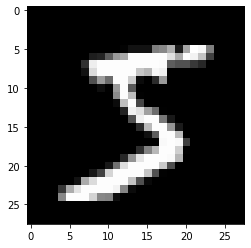

In [68]:
plt.imshow(X_train[0], cmap='gray');

In [75]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train[0].shape

(28, 28, 1)

# To categorical

In [56]:
y_train_cat = to_categorical(y_train, num_classes=10, dtype ="uint8")
y_test_cat = to_categorical(y_test, num_classes=10, dtype ="uint8")
print("y_train_cat.shape =",y_train_cat.shape)
print("y_test_cat.shape =", y_test_cat.shape)
pp.pprint(y_train_cat[0])

y_train_cat.shape = (60000, 10)
y_test_cat.shape = (10000, 10)
array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)


label is: Number 0


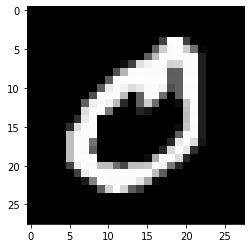

In [149]:
labels = ["Number 0",
          "Number 1",
          "Number 2",
          "Number 3",
          "Number 4",
          "Number 5",
          "Number 6",
          "Number 7",
          "Number 8",
          "Number 9"]

def categorical_to_id(arr_cat, labels=None):
    res = -1
    for i in range(len(arr_cat)):
        if arr_cat[i]:
            res = i
            break
    if labels is None:
        return res
    return labels[res]

item = 21

print("label is:", categorical_to_id(y_train_cat[item], labels))
plt.imshow(X_train[item], cmap='gray');

In [78]:
def get_model(X):
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (4,4), activation='relu', padding='same', input_shape=X[0].shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

model = get_model(X_train)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         136       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)               

# Train 

In [80]:
es = EarlyStopping(patience = 5)

history = model.fit(X_train, 
                    y_train_cat,
                    validation_split = 0.3, # auto val generation
                    batch_size = 32,
                    epochs = 5,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/5
1313/1313 [==============================] - 29s 21ms/step - loss: 2.1194 - accuracy: 0.2045 - val_loss: 2.0196 - val_accuracy: 0.2089
Epoch 2/5
1313/1313 [==============================] - 27s 20ms/step - loss: 1.9956 - accuracy: 0.2122 - val_loss: 1.9880 - val_accuracy: 0.2136
Epoch 3/5
1313/1313 [==============================] - 29s 22ms/step - loss: 1.9589 - accuracy: 0.2284 - val_loss: 1.8761 - val_accuracy: 0.2714
Epoch 4/5
1313/1313 [==============================] - 29s 22ms/step - loss: 1.5289 - accuracy: 0.4157 - val_loss: 1.2522 - val_accuracy: 0.5372
Epoch 5/5
1313/1313 [==============================] - 27s 20ms/step - loss: 0.7107 - accuracy: 0.7667 - val_loss: 0.4046 - val_accuracy: 0.8663


# Plot results

In [131]:
def plot_history(history, labels = ["loss"]):
    h = history.history
    with plt.style.context('seaborn-deep'):
        fig, ax = plt.subplots(1, max(2,len(labels)), figsize=(15, 4))
        x_axis = np.arange(len(h[labels[0]]))
        for i in range(len(labels)):
            l = labels[i]
            L = l.capitalize()
            ax[i].set_title(l)
            ax[i].plot(x_axis, h[l], color="blue", linestyle=":", marker="X", label="Train "+L)
            ax[i].plot(x_axis, h['val_'+l], color="orange", linestyle="-", marker="X", label="Val "+L)
            ax[i].grid(axis="x", linewidth=0.5)
            ax[i].grid(axis="y", linewidth=0.5)
            ax[i].legend()
        plt.show()

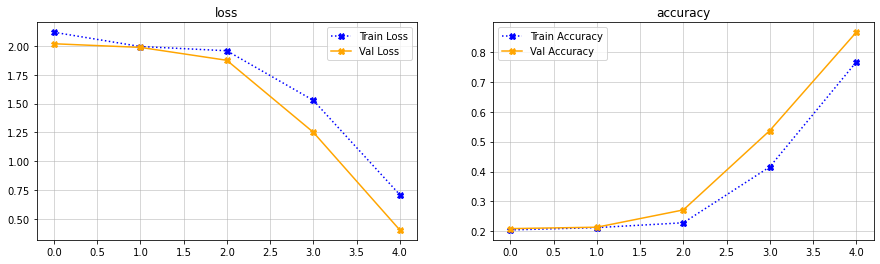

In [130]:
plot_history(history, ["loss", "accuracy"])

# Evaluation vs test set

In [82]:
res = model.evaluate(X_test, y_test_cat, verbose = 1)
print(f'The accuracy on the test set is of {res[1]*100:.2f} %')

313/313 [==============================] - 3s 9ms/step - loss: 0.4009 - accuracy: 0.8693
The accuracy on the test set is of 86.93 %


In [146]:
model.predict(X_test)

array([[1.03352750e-06, 1.71291773e-04, 1.77900530e-02, ...,
        9.81079996e-01, 1.70364075e-14, 6.06243077e-07],
       [1.69893667e-07, 4.48315125e-03, 9.95162964e-01, ...,
        3.41266947e-04, 1.33264514e-16, 6.70170859e-15],
       [1.65387348e-03, 9.94628847e-01, 9.32386727e-04, ...,
        4.41743441e-06, 2.33719940e-03, 1.46670104e-07],
       ...,
       [3.83029919e-06, 6.25696121e-05, 3.89114439e-06, ...,
        6.84602419e-04, 8.21099151e-04, 1.00558385e-01],
       [1.93734840e-02, 2.57317326e-03, 6.81413040e-02, ...,
        2.85640657e-02, 2.70486195e-02, 5.43044284e-02],
       [5.32048270e-02, 3.71932838e-05, 1.22127123e-04, ...,
        6.43704379e-06, 4.72970947e-04, 1.50836995e-05]], dtype=float32)

# Predict one observation

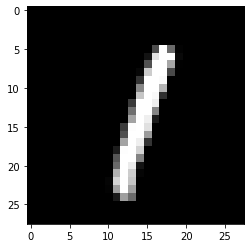

Prediction is = Number 1 (99.91%)


In [176]:
label = 5

predicted = list(model.predict(np.array([X_test[label]]))[0])
#print("prediction table:", predicted)
plt.imshow(X_test[label], cmap='gray')
plt.show()

predicted_label = labels[predicted.index(max(predicted))]
print("Prediction is =", predicted_label, f"({max(predicted)*100:.2f}%)")

# Class Scores

In [182]:
print(f"Prediction table for '{predicted_label}':")
print("\n",predicted)

Prediction table for 'Number 1':

 [0.00021510555, 0.99914587, 0.00042324836, 3.05158e-08, 3.9256654e-05, 5.286392e-12, 2.3547776e-13, 5.5486765e-07, 0.00017592404, 2.5604643e-09]


# Save

In [184]:
joblib.dump(model, f'model_digits.joblib')

2023-04-17 23:41:11.560063: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://e402c9da-5e2d-4386-a46d-728e1e9d7dd5/assets


['model_digits.joblib']